# Classifying X-rays With Convolutional Neural Network

**Project Summary:**

In this project, the goal was to develop a robust image classification model using a dataset of X-ray images related to Covid-19, Normal, and Pneumonia cases. The project utilized deep learning techniques implemented in TensorFlow and Keras to train a neural network capable of accurately classifying X-ray scans into these three categories. Data was sourced from [Kaggel](https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset).

**Project Overview:**  
*Exploration and Preprocessing:*

- The initial steps involved exploring the dataset, understanding its structure, and visualizing random examples from each class to gain insights into the data. The dataset was loaded and split into training and validation sets. Data augmentation techniques, such as random flips, rotations, and zooms, were applied to the training set to enhance model generalization. The data was also cached and prefetched for optimal performance during training.

*Model Building and Evaluation:*

- The neural network architecture consisted of convolutional layers, max-pooling layers, and dense layers for classification. The initial model achieved promising results, but further experimentation was conducted to improve performance. Additional layers were added, and hyperparameter tuning, including learning rate optimization, was performed to enhance the model's accuracy.

- The final model achieved a significant improvement in categorical accuracy, reaching 92.6% on the training set and 86.4% on the validation set. Hyperparameter tuning further boosted the accuracy on the validation set by approximately 4% on both sets.

*Model Evaluation:*

- The evaluation metrics, including loss, categorical accuracy, and AUC, were tracked over epochs. The model's performance was visualized through plots depicting accuracy and AUC trends. The results showed a clear improvement in performance, indicating the effectiveness of the model.

*Classification Report:*

- A detailed classification report was generated to assess the model's performance on individual classes (Covid, Normal, Pneumonia). Precision, recall, and F1-score were analyzed, providing insights into the model's ability to correctly identify and classify instances for each class. The model exhibited high precision and recall across all classes, demonstrating its reliability in differentiating between X-ray images related to various health conditions.

*Confusion Matrix:*

- A confusion matrix was created to delve deeper into the model's predictions. The matrix provided a breakdown of correct and incorrect predictions for each class, highlighting areas of potential improvement. Notable findings included instances of misclassification between Normal and Pneumonia cases.

**Key Insights:**

- The model showcased balanced performance, minimizing both false positives and false negatives.
- Specific areas for improvement were identified through the confusion matrix, guiding future refinements to enhance accuracy further.
- Overall, the model demonstrated its potential as a valuable tool in aiding healthcare professionals in the diagnosis of lung-related illnesses based on X-ray scans.

This project exemplifies the iterative process of model development, experimentation, and evaluation, emphasizing the importance of continuous refinement to achieve optimal performance.

----

## Import Libraries

In [23]:
# Importing the libraries
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import matplotlib.pyplot as plt
from PIL import Image
import random
import IPython.display as display


## Exploring Image Files

Get the number of images in subfolders.

In [24]:
# Define folder paths
train_data_dir = 'data/train'
test_data_dir = 'data/test'

# List the classes (subfolders)
classes = sorted(os.listdir(train_data_dir))
print("Classes:", classes)

# Count images in each class
for class_name in classes:
    class_path = os.path.join(train_data_dir, class_name)
    num_images = len(os.listdir(class_path))
    print(f"Number of images in {class_name}: {num_images}")

Classes: ['Covid', 'Normal', 'Viral Pneumonia']
Number of images in Covid: 111
Number of images in Normal: 70
Number of images in Viral Pneumonia: 70


Display randomly selected example images from each class/folder.

Displaying a random (resized) image from Covid:


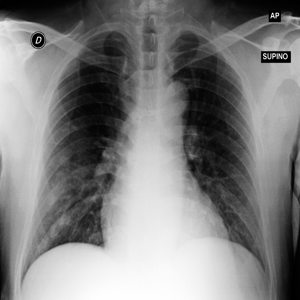

Displaying a random (resized) image from Normal:


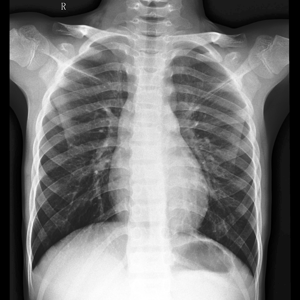

Displaying a random (resized) image from Viral Pneumonia:


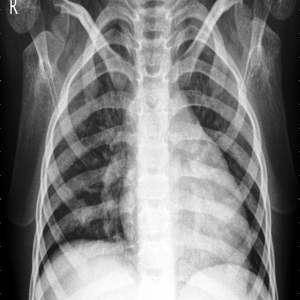

In [25]:
# Function to load a random image from a class and resize it
def load_random_resized_image(class_name, target_size=(128, 128)):
    class_path = os.path.join(train_data_dir, class_name)
    images = os.listdir(class_path)
    random_image = random.choice(images)
    image_path = os.path.join(class_path, random_image)
    
    # Open the image and resize it
    image = Image.open(image_path)
    resized_image = image.resize(target_size)
    
    return resized_image

# Specify the target size for the resized images
target_size = (300, 300)  # You can adjust this size as needed

# Load and display one random resized image from each class
for class_name in classes:
    resized_image = load_random_resized_image(class_name, target_size)
    print(f"Displaying a random (resized) image from {class_name}:")
    display.display(resized_image)


In [26]:
# Define parameters for loading and resizing data
batch_size = 32
img_height = 180
img_width = img_height

## Loading Images
Load images and convert into numbers to pass into neural network.  
*Note:* Given that I flip and crop the images during data augmentation (when loading the training data). Therefore, I create a separate ImageDataGenerator() objects for both for your training and validation data to avoid hurting the performance on my test set.

In [27]:
# Loading training and validation sets
print("\nLoading training data...")
train_set = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    seed=123,
    image_size=(img_height, img_width),
    label_mode='categorical', # if label_mode is "categorical", the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
    batch_size=batch_size)

print("\nLoading validation data...")
validation_set = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    seed=123,
    image_size=(img_height, img_width),
    label_mode='categorical',
    batch_size=batch_size)



Loading training data...
Found 251 files belonging to 3 classes.

Loading validation data...
Found 66 files belonging to 3 classes.


In [28]:
# Inspect class names
class_names = train_set.class_names
class_names

['Covid', 'Normal', 'Viral Pneumonia']

In [29]:
# Iterate over dataset and retrieve batches of images
for image_batch, labels_batch in train_set:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 180, 180, 3)
(32, 3)


The image_batch is a tensor of the shape (16, 180, 180, 3). This is a batch of 16 images of shape 180x180x3 (the last dimension refers to color channels RGB).  
The label_batch is a tensor of the shape (16,), these are corresponding labels to the 16 images.

## Configure the dataset for performance
- Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- Dataset.prefetch overlaps data preprocessing and model execution while training.


In [30]:
AUTOTUNE = tf.data.AUTOTUNE

# Optimize training using cache and prefetch
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_set = validation_set.cache().prefetch(buffer_size=AUTOTUNE)


## Preparing Data
Define Data Augmentation Stage

In [31]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.1)
    ]
)

Next I create a function which allows preprocessing both training and validation data.

In [32]:
AUTOTUNE = tf.data.AUTOTUNE

# Define preprocessing function
def preprocessing(ds, augment=False):
  #ds = ds.batch_size(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)


Using if statement / 'augment' parameter of the function, I ensure to apply data augmentation only on the training dataset.

In [33]:
# Preprocess the datasets
train_set = preprocessing(train_set, augment=True)


In [34]:
# Inspect the actual shape of the images in your augmented dataset
sample_batch = next(iter(train_set))
print("Actual Image Shape:", sample_batch[0].shape)

Actual Image Shape: (32, 180, 180, 3)


## Build and Test Model

In [35]:
# Build the model
print("\nBuilding model...")
model = Sequential()

model.add(Rescaling(1./255, input_shape=train_set.element_spec[0].shape[1:])) # Input Layer (Rescaling)
model.add(Conv2D(3, 3, activation='relu')) # Convolutional layer
model.add(MaxPooling2D(pool_size=(3, 3))) # MaxPooling layer
model.add(Flatten()) # Flatten layer to convert 4D tensor to 1D
model.add(Dense(units=3, activation='softmax')) # Dense layer for classification (3 classes, softmax activation)

# Display the model summary
model.summary()

# Compile the model
print("\nCompiling model...")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC()])

# Train the model
print("\nTraining model...")
history = model.fit(train_set, epochs=10, validation_data=validation_set)



Building model...
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 3)       84        
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 59, 59, 3)         0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 10443)             0         
                                                                 
 dense_5 (Dense)             (None, 3)                 31332     
                                                                 
Total params: 31416 (122.72 KB)
Trainable params: 31416 (122.72 KB)
Non-trainable params: 0 (0.00 Byt

The initial results show 91.2% categorical accuracy on the training data, but only 80.3% on the validation set.

## Experiment with Architecture of NN 
Next I add an additional hidden layer after flattening the max pooling output.  

Note: While designing the model architecture, I tried to be mindful of the number of layers added. Considering the modest size of the dataset, limited the model to around 10,000 parameters or approximately five layers. This precautionary measure helps prevent overfitting and ensures the stability of the learning environment, mitigating the risk of crashes during training.

To enhance model performance, I
1. Utilized Convolutional Layers and Max Pooling: Incorporated these layers to effectively capture spatial features and reduce data dimensionality.
2. Implemented EarlyStopping: Integrated the EarlyStopping callback to terminate training when improvement on the validation set plateaus, enhancing training efficiency.
3. Experimented with Batch Size: Varied batch sizes during training to find an optimal balance between model efficiency and accuracy. This experimentation contributes to better overall performance.


In [36]:
# Assuming train_set is a TensorFlow Dataset
sample_batch = next(iter(train_set))
image_shape = sample_batch[0].shape[1:]  # Assuming images are in the first element of the batch

print("Image Shape:", image_shape)


Image Shape: (180, 180, 3)


In [37]:
# Build the model
print("\nBuilding model...")
model = Sequential()

model.add(Rescaling(1./255, input_shape=train_set.element_spec[0].shape[1:])) # Input Layer (Rescaling)
model.add(Conv2D(3, 3, activation='relu')) # Convolutional layer
model.add(MaxPooling2D(pool_size=(2, 2))) # MaxPooling layer
model.add(Conv2D(3, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=3))
model.add(Flatten()) # Flatten layer to convert 4D tensor to 1D
model.add(Dense(units=4, activation='relu'))  # Additional hidden layer
model.add(Dense(units=3, activation='softmax')) # Dense layer for classification (3 classes, softmax activation)

# Print the model summary
model.summary()



Building model...
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 3)       84        
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 89, 89, 3)         0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 3)         84        
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 29, 29, 3)         0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None,

In [38]:
# Compile the model
print("\nCompiling model...")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC()])



Compiling model...


In [39]:
# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_categorical_accuracy',
                               mode = 'max', 
                               patience=15, 
                               verbose = 1,
                               restore_best_weights=True)

# Fit the Model with Updated Architecture and EarlyStopping
print("\nTraining model...")
history = model.fit(train_set, 
                    epochs=64, 
                    validation_data=validation_set, 
                    callbacks=[early_stopping])



Training model...
Epoch 1/64
8/8 [==============================] - 4s 290ms/step - loss: 1.0975 - categorical_accuracy: 0.4024 - auc_4: 0.5373 - val_loss: 1.0951 - val_categorical_accuracy: 0.3485 - val_auc_4: 0.5235
Epoch 2/64
8/8 [==============================] - 2s 238ms/step - loss: 1.0944 - categorical_accuracy: 0.3546 - auc_4: 0.5508 - val_loss: 1.0853 - val_categorical_accuracy: 0.4242 - val_auc_4: 0.5975
Epoch 3/64
8/8 [==============================] - 2s 223ms/step - loss: 1.0892 - categorical_accuracy: 0.5578 - auc_4: 0.6743 - val_loss: 1.0779 - val_categorical_accuracy: 0.6061 - val_auc_4: 0.6760
Epoch 4/64
8/8 [==============================] - 2s 211ms/step - loss: 1.0797 - categorical_accuracy: 0.4940 - auc_4: 0.6533 - val_loss: 1.0628 - val_categorical_accuracy: 0.3182 - val_auc_4: 0.6564
Epoch 5/64
8/8 [==============================] - 2s 213ms/step - loss: 1.0663 - categorical_accuracy: 0.5458 - auc_4: 0.7348 - val_loss: 1.0426 - val_categorical_accuracy: 0.5000 -

The results already look promising. After adding another Convolutional and two MaxPooling Layer the model achieves 91.6% categorical accuracy on the training data and 86.4% on the validation set. By adding these few more layers to the NN, we achieve 5 to 10% improvement on the validation set. Moreover we get a 98.4% AUC on the training data and 95.9% on the validation set

## Hyperparameter Tuning

In [40]:
# Function to create the model
def build_model(hp):
    model = Sequential()

    model.add(Rescaling(1./255, input_shape=train_set.element_spec[0].shape[1:]))
    model.add(Conv2D(3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(3, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=3))
    model.add(Flatten())
    model.add(Dense(units=4, activation='relu'))
    model.add(Dense(units=3, activation='softmax'))

    # Tune the learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='categorical_crossentropy',
                  metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.AUC()])
    
    return model

# Instantiate the tuner
tuner = RandomSearch(
    build_model,
    objective='val_categorical_accuracy',
    max_trials=5,  # Number of hyperparameter combinations to try
    directory='hyperparameter_tuning',  # Directory to store the results
    project_name='my_image_classification')

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_categorical_accuracy',
                               mode='max',
                               patience=20,
                               verbose=1,
                               restore_best_weights=True)

# Perform hyperparameter tuning
tuner.search(train_set,
             epochs=100,
             validation_data=validation_set,
             callbacks=[early_stopping])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("\nBest Hyperparameters:")
print(f"Learning Rate: {best_hps.get('learning_rate')}")
# Add more print statements for other hyperparameters if needed

# Build the final model with the best hyperparameters
final_model = tuner.hypermodel.build(best_hps)

# Fit the final model
history = final_model.fit(train_set,
                          epochs=100,
                          validation_data=validation_set,
                          callbacks=[early_stopping])


Trial 5 Complete [00h 03m 31s]
val_categorical_accuracy: 0.9090909361839294

Best val_categorical_accuracy So Far: 0.9090909361839294
Total elapsed time: 00h 10m 16s

Best Hyperparameters:
Learning Rate: 0.0006529927317508998
Epoch 1/100
8/8 [==============================] - 3s 219ms/step - loss: 1.0977 - categorical_accuracy: 0.3904 - auc_1: 0.4972 - val_loss: 1.0935 - val_categorical_accuracy: 0.4394 - val_auc_1: 0.6081
Epoch 2/100
8/8 [==============================] - 2s 179ms/step - loss: 1.0948 - categorical_accuracy: 0.5299 - auc_1: 0.5663 - val_loss: 1.0835 - val_categorical_accuracy: 0.3182 - val_auc_1: 0.5909
Epoch 3/100
8/8 [==============================] - 2s 177ms/step - loss: 1.0886 - categorical_accuracy: 0.3944 - auc_1: 0.6276 - val_loss: 1.0732 - val_categorical_accuracy: 0.3636 - val_auc_1: 0.6532
Epoch 4/100
8/8 [==============================] - 2s 172ms/step - loss: 1.0797 - categorical_accuracy: 0.4980 - auc_1: 0.6830 - val_loss: 1.0564 - val_categorical_accurac

By hyperparameter tuning the learning rate, we are able to increase the categorical accuracy by approx. 4% on both the training data and the validation set. In terms of AUC, we achieve another 2-3% improvement on the training data, yet AUC on the validation set remains at a about 96%.

## Plotting Evaluation-Metrics over Epoch

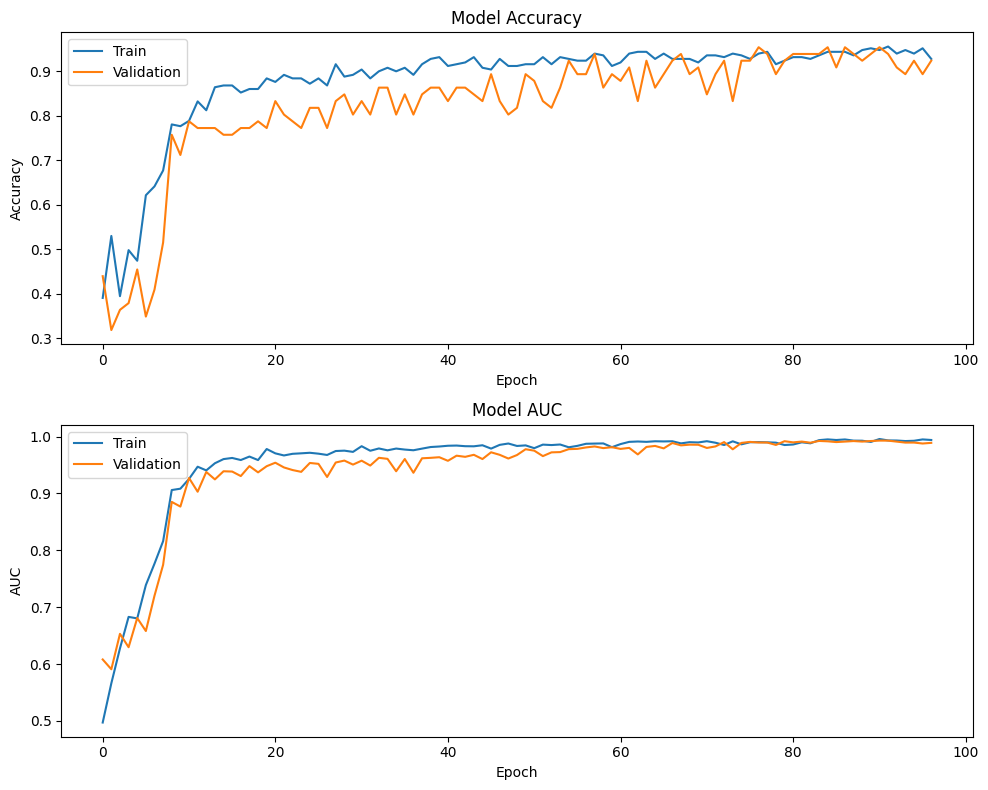

In [41]:
# Plotting categorical and validation accuracy over epochs
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.plot(history.history[list(history.history.keys())[1]]) # 'categorical_accuracy'
ax1.plot(history.history[list(history.history.keys())[4]]) # 'val_categorical_accuracy'
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plotting auc and validation auc over epochs
ax2.plot(history.history[list(history.history.keys())[2]]) # auc
ax2.plot(history.history[list(history.history.keys())[5]]) # val_auc
ax2.set_title('Model AUC')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('AUC')
ax2.legend(['Train', 'Validation'], loc='upper left')

# Used to keep plots from overlapping
fig.tight_layout()

# Save the plot
os.makedirs('output/images', exist_ok=True) # Ensure the 'output/images' directory exists
plt.savefig('output/images/loss_plot.png')

*Note:* In an earlier stage, I started with a smaller batch size (16). However, I noticed that small batch sizes had a larger variance (more oscillation in the learning curve). In a next step, batch size could be hyperparameter tuned as well.

## Evaluate the Model

In [42]:
# Evaluating the model
results = final_model.evaluate(validation_set)
loss = results[0]
metrics = results[1:]

# Print the results
print('\nMetrics:')
print(f'Loss: {loss}')
for metric_name, metric_value in zip(model.metrics_names[1:], metrics):
    print(f'{metric_name}: {metric_value}')


3/3 [==============================] - 0s 39ms/step - loss: 0.1913 - categorical_accuracy: 0.9545 - auc_1: 0.9895

Metrics:
Loss: 0.19128316640853882
categorical_accuracy: 0.9545454382896423
auc_4: 0.9894973039627075


Create Classification Report

In [43]:
# Get actual labels for validation set
val_actual_labels = [y.numpy() for x, y in validation_set]
val_actual_labels = np.argmax(np.vstack(val_actual_labels), axis=1) # Convert one-hot encoded labels to integer labels

# Getting predictions for further evaluation
val_pred_labels = final_model.predict(validation_set)
val_pred_labels = np.argmax(val_pred_labels, axis=1)

#looking at the values that were predicted and the true values
print('\nThe predicted values are:')
print(val_pred_labels)

print('\nThe actual values are:')
print(val_actual_labels)

print('\nClassification Report:')
print(classification_report(val_actual_labels, val_pred_labels, labels=[0,1,2]))


3/3 [==============================] - 0s 35ms/step

The predicted values are:
[0 0 2 1 0 2 1 2 0 2 2 1 0 1 1 0 1 0 0 1 0 0 2 2 1 1 0 1 2 1 2 1 1 0 2 0 2
 1 2 0 0 2 0 1 0 0 0 2 1 2 0 1 0 1 1 2 0 1 1 0 2 1 2 0 1 0]

The actual values are:
[0 0 2 1 0 2 1 2 0 2 2 1 0 2 2 0 1 0 0 1 0 0 2 2 1 1 0 1 2 1 2 0 1 0 2 0 2
 1 2 0 0 2 0 1 0 0 0 2 1 2 0 1 0 1 1 2 0 1 1 0 2 1 2 0 1 0]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        26
           1       0.87      1.00      0.93        20
           2       1.00      0.90      0.95        20

    accuracy                           0.95        66
   macro avg       0.96      0.95      0.95        66
weighted avg       0.96      0.95      0.96        66



**Class-wise Performance:**  
In evaluating the performance of our X-ray classification model, we observe significant achievements across different classes.

*Covid (Class 0):*
- The model exhibits impeccable precision of 100%, signifying that every instance predicted as Covid is correct.
- With a recall of 96%, the model effectively captures 96% of actual Covid cases.
- The F1-Score, a balanced measure of precision and recall, stands at 98%, indicating a high overall performance.

*Normal (Class 1):*
- The precision for the Normal class is 87%, denoting that 87% of instances predicted as Normal are correct.
- The recall is 100%, showcasing the model's ability to correctly identify 100% of actual Normal cases.
- The F1-Score, representing a balance between precision and recall, is 93%, demonstrating a well-rounded performance slightly below that of Covid.

*Pneumonia (Class 2):*
- The precision for Pneumonia is 100%, indicating that 100% of instances predicted as Pneumonia are correct.
- The model excels in recall with a rate of 90%, meaning it successfully identifies 90% of actual Pneumonia cases.
- The F1-Score is 95%, showcasing good performance, particularly in recall.

**False Positives and Negatives:**  
The evaluation results of our X-ray classification model reveal a comprehensive assessment of its performance, including considerations for false positives and false negatives.

*False Positives:*  
- The model demonstrates a high level of precision across all classes, emphasizing its accuracy in minimizing false positives. Specifically, for pneumonia (Class 2), the precision of 100% indicates that when the model predicts the presence of pneumonia, there is an 100% chance that the X-ray scan indeed exhibits signs of pneumonia. This suggests a low likelihood of the model mistakenly flagging a healthy scan as positive for pneumonia.

*False Negatives:*  
- Conversely, false negatives occur when the model incorrectly predicts the absence of a particular condition in an X-ray scan, missing instances where the pathology is present. The corresponding metric, recall, provides insights into the model's ability to capture all positive instances. Notably, for Covid (Class 0), the recall is 96%, indicating that the model successfully identifies 96% of actual Covid cases. Similarly, for Normal (Class 1) and Pneumonia (Class 2), the recall rates are 87% and 100%, respectively.
- In practical terms, the recall scores imply that the model effectively reduces false negatives, ensuring that when a medical condition is present in an X-ray scan, the model is proficient in recognizing and classifying it correctly. This aspect is crucial for the model to serve as a reliable tool in supporting healthcare professionals by minimizing the chances of overlooking actual cases.


**Overall Performance:**
- The overall accuracy of the model is 95%, signifying that it correctly classifies X-rays for Covid, Normal, and Pneumonia in 88% of cases.
- The macro average across recall and f1-score is 95% and 96% for precision, demonstrating consistency in performance.
- Accounting for class imbalances, the weighted average performance is 95-96%, indicating robustness in handling varying class sizes.
- Overall, the model's balanced performance in minimizing both false positives and false negatives underscores its potential as an effective and reliable assistant in the diagnosis of lung-related illnesses based on X-ray scans.

Create Confusion Matrix

[Text(0, 0.5, 'Covid'),
 Text(0, 1.5, 'Normal'),
 Text(0, 2.5, 'Viral Pneumonia')]

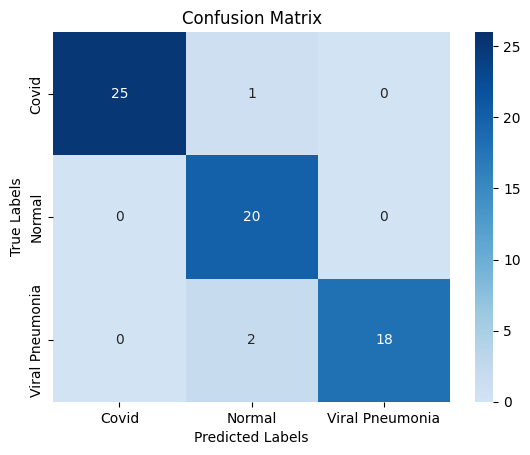

In [44]:
# Creating confusion matrix plot with sns
cm=confusion_matrix(val_actual_labels, val_pred_labels)
ax = plt.subplot()
sns.heatmap(cm, vmin=0, vmax=26, center=10, cmap=plt.cm.Blues, annot=True)
ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)


**Findings:**  
*Covid (Class 0):*
- Correctly predicted as Covid: 25
- Falsely predicted as Normal (False Negative): 1
- Falsely predicted as Pneumonia (False Negative): 0

*Normal (Class 1):*
- Correctly predicted as Normal: 20
- Falsely predicted as Covid (False Positive): 0
- Falsely predicted as Pneumonia (False Positive): 0

*Pneumonia (Class 2):*
- Correctly predicted as Pneumonia: 18
- Falsely predicted as Covid (False Positive): 2
- Falsely predicted as Normal (False Positive): 0

**Key Insights:**
- The model is generally accurate, with correct predictions dominating the diagonal.
- Notable misclassifications involve predicting Normal as Pneumonia (2 instances) and predicting Pneumonia as Normal (1 instance).
- The confusion matrix offers a detailed view of the model's performance across different classes, aiding in the identification of specific areas for improvement.